This notebook is for illustration, and is implemented in numpy.

The standalone file grf.py implements 1d and 2d Gaussian random field generators in pytorch. The logic is the same.

## Gaussian Random Field

The goal of this notebook is to introduce the concept of a Gaussian random field, and to implement a Gaussian random field generator.

### Random variables

First, let us recall that a random variable $X$ is a object that allows us to take random draws. Each random variable has a distribution. For example, $X$ is a normal random variable with variance $\sigma^2$ and mean $\mu$, written 
$$
X \sim \mathcal{N}(\mu,\sigma^2),
$$
if the distribution of $X$ has the density,
$$
\rho(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-(x-\mu)^2/2\sigma^2}.
$$
This means that for any two reals $a<b$, the probability that the random variable $X$ lies in the interval $[a,b]$ is given by
$$
P[a\le X \le b] = \int_a^b \rho(x) \, dx.
$$

### Illustration 

Let us illustrate this! We sample $X$ from a normal distribution and plot the histogram. We compare the observed distribution of values against the analytical expression.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

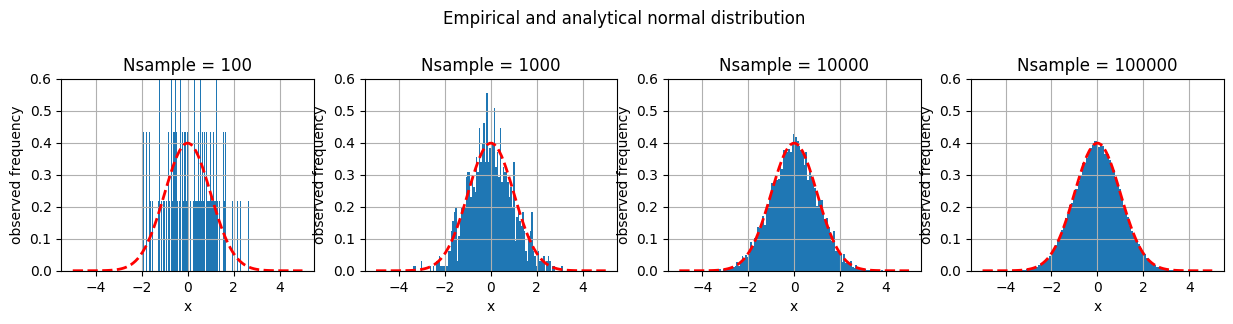

In [ ]:
def rho(x):
    '''
    Define the analytical standard normal distribution.
    '''
    return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

fig, axs = plt.subplots(1,4, figsize=(15,3))
Nsample_vals = [100, 1000, 10_000, 100_000]

for i in range(4):
    Nsample = Nsample_vals[i]
    X = np.random.randn(Nsample) # sample from standard Gaussian

    axs[i].hist(X, bins=100, density=True)
    x = np.linspace(-5,5,100)
    axs[i].plot(x, rho(x),'r--', linewidth=2)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('observed frequency')
    axs[i].grid()
    axs[i].set_ylim([0,.6])
    axs[i].set_title(f'Nsample = {Nsample}')

plt.subplots_adjust(top=0.75)
plt.suptitle('Empirical and analytical normal distribution')
plt.show()

Thus, with many random draws the empirically observed frequency of values of $X$ statistically matches the correct normal distribution.

### Gaussian random fields

A Gaussian random field is like a Gaussian random variable, but random draws are functions, rather than just numeric values.

* Gaussian (normal) random variable $X$: Each draw is a numeric value (real number)
* Multivariate Gaussian random variable $X$: Each draw is a vector $(X_1, \dots, X_d) \in \mathbb{R}^d$, where $X_j$ has Gaussian distribution
* Gaussian random field $u(z)$: Each draw is a function $u(z)$, depending on coordinate $z$.

To further highlight the connection between multivariate Gaussian random variables and Gaussian random fields, we could essentially think of a Gaussian random field as multivariate random variable with components $(u(z))_{z}$ where the "index" $z$ can take infinitely many values. The link should hopefully become clearer after reading the rest of this notebook.

### How do we define Gaussian random fields (GRF)?

One way to define GRFs is as follows: We fix a basis of our function space $\phi_1(z),\phi_2(z),\dots$, and we expand $u(z)$ in this basis as follows:

$$
u(z) = \sum_{k=1}^\infty \lambda_k \eta_k \phi_k(z).
$$
Here
* $\lambda_1,\lambda_2,\dots \ge 0$ is a fixed sequence of parameters, such that $\lambda_k \to 0$ as $k\to \infty$,
* all the coefficients $\eta_k \sim \mathcal{N}(0,1)$ are normal random variables like before, and they are chosen independently.

The coefficients $\lambda_1, \lambda_2, \dots$ need to decay sufficiently fast to guarantee that the expansion for $u(z)$ converges. Specification of the basis $(\phi_k)_{k\in \mathbb{N}}$ and the coefficients $(\lambda_k)_{k\in \mathbb{N}}$ defines the GRF.

### GRF with Fourier basis
A more concrete example of a Gaussian random field is when $\phi_k(z) = e^{2\pi i kz}$ is the Fourier basis. In this case, Fourier analysis tells us that the decay of the Fourier coefficients is related to the smoothness of the function $u(z)$: Faster decaying $\lambda_k$ correspond to smoother functions.

Let us illustrate this! We introduce a parameter $\alpha > 0$, and define $\lambda_k = (1+|k|)^{-\alpha}$. In practice, we truncate the expansion after finitely many terms.

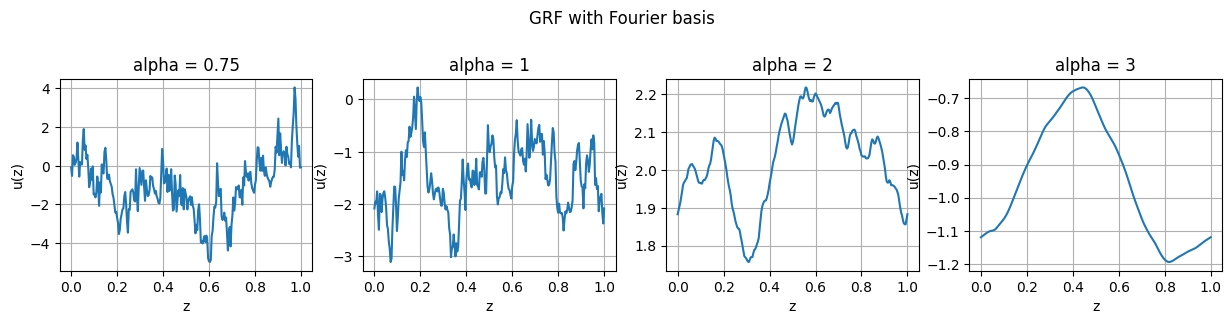

In [ ]:
def GRF1d_explicit(z, alpha, truncation=10):
    '''
    Sample from a Gaussian random field with Fourier basis, and explicit summation.
    '''
    #
    z = z.reshape(1,-1)
    k = np.arange(0, truncation, dtype=np.float32).reshape(-1,1) # Fourier wavenumbers k
    lmbda = (k+1)**(-alpha)
    # generate the coefficients (here made complex, since our basis is complex)
    eta = np.random.randn(truncation,1)  + 1j*np.random.randn(truncation,1)
    #
    Fourier_basis = np.exp(2*np.pi*1j*k*z) # shape (truncation,len(z))
    u = np.real( np.sum(lmbda*eta*Fourier_basis, axis=0) ) # shape (len(z),)
    return u

# generate a few 1d fields
N = 256 # number of grid points
alpha_vals = [.75,1, 2, 3]

fig, axs = plt.subplots(1,4, figsize=(15,3))

for i in range(4):
    alpha = alpha_vals[i]
    z = np.linspace(0,1,N)
    u = GRF1d_explicit(z,alpha,truncation=N)

    axs[i].plot(z,u)
    axs[i].set_xlabel('z')
    axs[i].set_ylabel('u(z)')
    axs[i].set_title(f'alpha = {alpha}')
    axs[i].grid()

plt.subplots_adjust(top=0.75)
plt.suptitle('GRF with Fourier basis')
plt.show()

As expected, we observe that the samples generated for smaller values of $\alpha$ are rougher, than the samples for larger values of $\alpha$.

### Another way to get the same

Instead of performing the summation explicitly as above, we can also just sample from a multivariate Gaussian in Fourier space and then transform back. Since we want to generate a real-valued function $u(x)$, I will use the real FFT (`np.fft.irfft` instead of `np.fft.ifft` for inverse FFT)

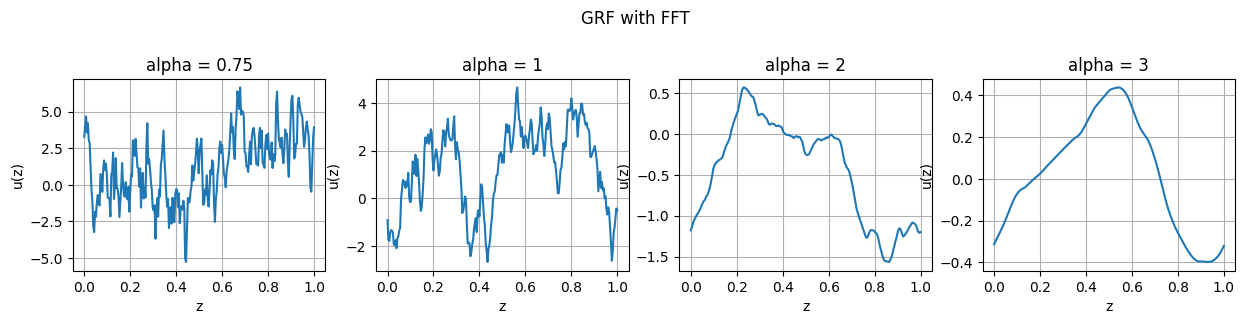

In [ ]:
def GRF1d(z, alpha):
    # get grid size
    N = len(z)

    # define wavenumber and coefficients
    k = np.fft.rfftfreq(N,1/N) # wavenumbers
    lmbda = (k+1)**(-alpha)    # decay parameters
    eta = np.random.randn(len(k)) + 1j*np.random.randn(len(k)) # random coefficients

    # Fourier coefficients of u
    uhat = lmbda*eta

    # transform back via (real) inverse FT
    u = np.fft.irfft(uhat, norm='forward')

    return u

# generate a few 1d fields
N = 256 # number of grid points
alpha_vals = [.75,1, 2, 3]

fig, axs = plt.subplots(1,4, figsize=(15,3))

for i in range(4):
    alpha = alpha_vals[i]
    z = np.linspace(0,1,N)
    u = GRF1d(z,alpha)

    axs[i].plot(z,u)
    axs[i].set_xlabel('z')
    axs[i].set_ylabel('u(z)')
    axs[i].set_title(f'alpha = {alpha}')
    axs[i].grid()

plt.subplots_adjust(top=0.75)
plt.suptitle('GRF with FFT')
plt.show()

### GRF in 2d with FFT

We can do exactly the same in 2d: Instead of the 1d FFT we use the 2d FFT.

**Note**: the concept is the same, but `rfft` (=real FFT) is a bit special in 2d, since it transforms a real-valued array of size `(Nx,Ny)` to a complex-valued array of size `(Nx,Ny/2)`. We won't go into the details of this, but the division by 2 takes into account that the total number of *real* degrees of freedom of a real-valued array of size `(Nx,Ny)` is `Nx*Ny`, whereas the number of *real-valued* degrees of freedom of a complex-valued array of size `(Nx,Ny)` is `2*Nx*Ny`: indeed, for complex arrays, there are now two *real-valued* degreees of freedom for each component, namely the real and imaginary parts. In our case, the vanilla Fourier transform takes a real-valued `(Nx,Ny)` array as input, and outputs a complex-valued array of size `(Nx,Ny)` after performing the Fourier transform. This means that the complex-valued array contains redundant information. Because of this, `np.fft.rfft2` can throw away half of the output coefficients without losing any information, resulting in a complex-valued array of size roughly `(Nx,Ny/2)`!

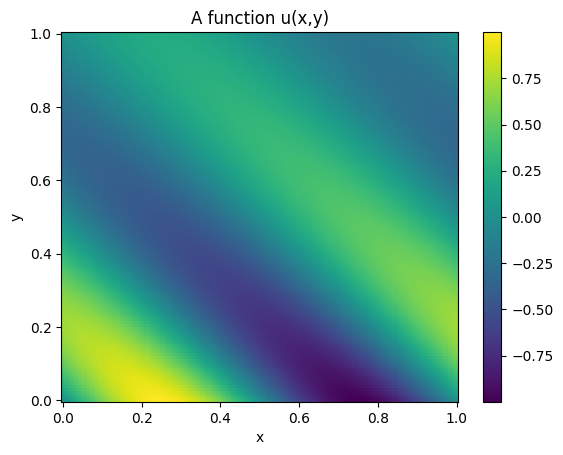

Shape of u: (128, 128)
Shape of uhat: (128, 65)


In [ ]:
N = 128
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)

u = np.sin(2*np.pi*(X+Y))*np.exp(-1.5*Y)

plt.figure()
plt.pcolor(X,Y,u)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('A function u(x,y)')
plt.show()

print(f'Shape of u: {u.shape}')
print(f'Shape of uhat: {np.fft.rfft2(u).shape}')

We now implement a function that generalized `GRF1d` to the two-dimensional case. We again specify an algebraic decay of the Fourier coefficients of order $\alpha>0$. Varying $\alpha$ allows us to control the smoothness of the samples.

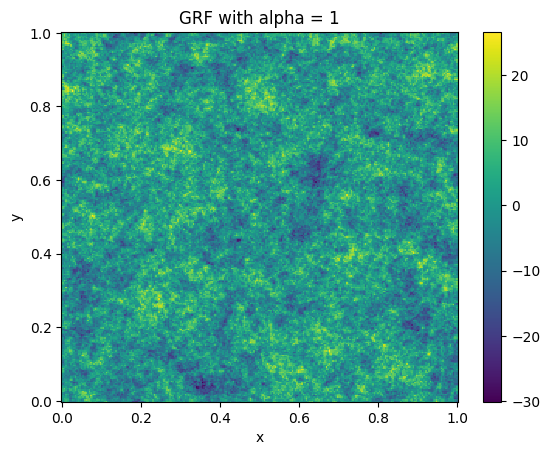

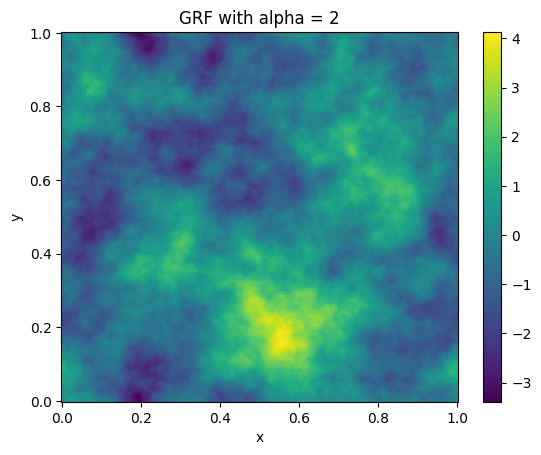

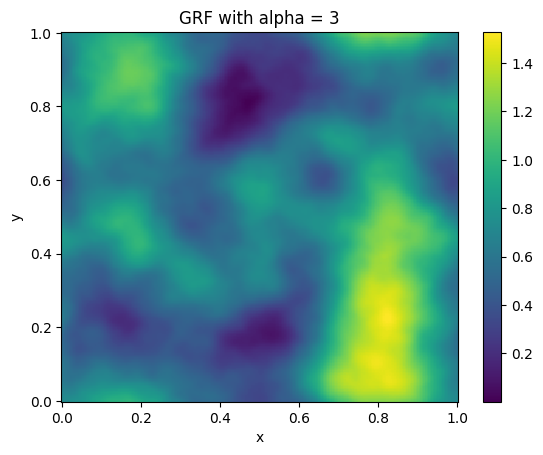

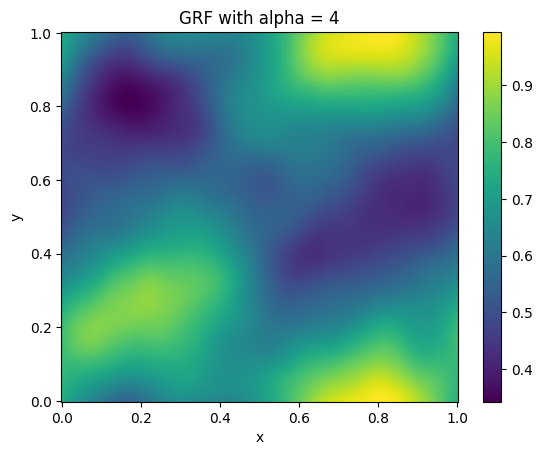

In [ ]:
def GRF2d(Nx, Ny, alpha):
    # define wavenumber and coefficients
    kx = np.fft.fftfreq(Nx,1/Nx)  # wavenumbers
    ky = np.fft.rfftfreq(Ny,1/Ny) # wavenumbers
    Kx,Ky = np.meshgrid(kx,ky)    # k = (kx,ky) wavevector in 2d
    K = np.sqrt(Kx**2+Ky**2).T    # wavenumber magnitude |k|

    #
    lmbda = (K+1)**(-alpha)    # decay parameters
    eta = (
        np.random.randn(*K.shape) + 1j*np.random.randn(*K.shape)
    ) # random coefficients

    # Fourier coefficients of u
    uhat = lmbda*eta

    # transform back via inverse FT
    u = np.fft.irfft2(uhat, norm='forward')

    return u

# generate a few 2d fields
N = 256 # number of grid points
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)
alpha_vals = [1,2, 3, 4]

for i in range(4):
    alpha = alpha_vals[i]
    u = GRF2d(N,N,alpha) # generate random field

    # plot
    plt.figure()
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GRF with alpha = {alpha}')
    plt.show()

As we can see, larger $\alpha$ produces smoother fields, and smaller $\alpha$ produces more small scale structure.

There is no canonical way to choose the coefficients $\lambda_k$. For example, we can add another degree of freedom to generate fields which are relatively smooth, but have a wider range of feature scales at the same time. To this end, we define the coefficients $\lambda_k = (\tau+|k|)^{-\alpha}$, with an additional parameter $\tau>0$. These coefficients are all of roughly equal size $\tau^{-\alpha}$ when $|k| \lesssim \tau$, but decay like $|k|^{-\alpha}$ for large values of $|k|$. Thus, the decay in the Fourier spectrum only sets in for $|k| \ge \tau$. Larger values of $\tau$ can thus increase the variability of the fields without changing the basic regularity (=asymptotic Fourier decay).

Let's illustrate this with $\alpha=3$!

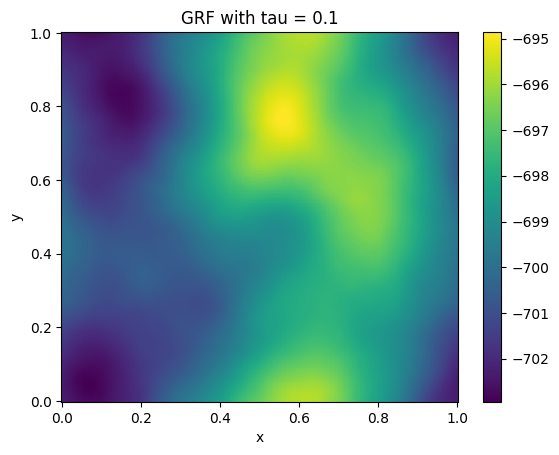

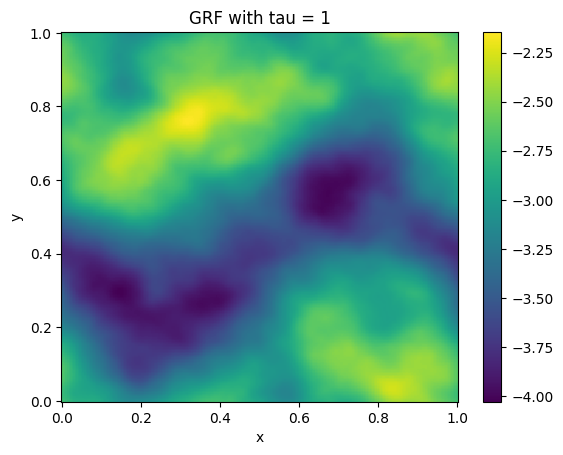

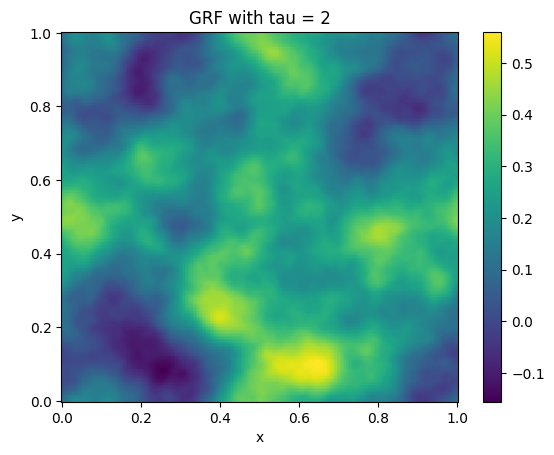

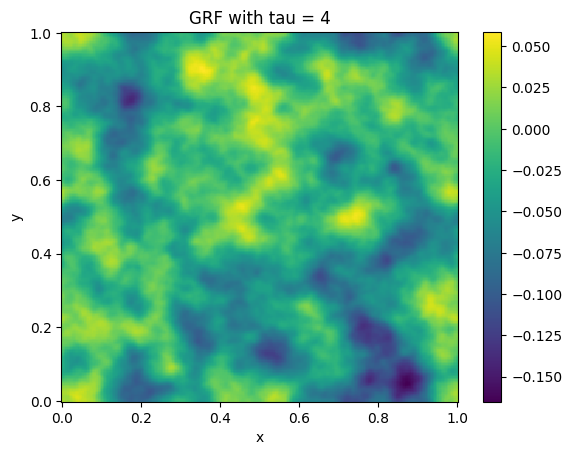

In [ ]:
# updated version of GRF2d with optional tau parameter
def GRF2d(Nx, Ny, alpha, tau=1):
    # define wavenumber and coefficients
    kx = np.fft.fftfreq(Nx,1/Nx)  # wavenumbers
    ky = np.fft.rfftfreq(Ny,1/Ny) # wavenumbers
    Kx,Ky = np.meshgrid(kx,ky)    # k = (kx,ky) wavevector in 2d
    K = np.sqrt(Kx**2+Ky**2).T    # wavenumber magnitude |k|

    #
    assert tau > 0, 'tau must be positive'
    lmbda = (K+tau)**(-alpha)    # decay parameters
    eta = (
        np.random.randn(*K.shape) + 1j*np.random.randn(*K.shape)
    ) # random coefficients

    # Fourier coefficients of u
    uhat = lmbda*eta

    # transform back via inverse FT
    u = np.fft.irfft2(uhat, norm='forward')

    return u

# generate a few 2d fields
N = 256 # number of grid points
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)
alpha = 3 # fixing alpha value
tau_vals = [.1,1,2,4]

for i in range(4):
    tau = tau_vals[i]
    u = GRF2d(N,N,alpha,tau=tau) # generate random field

    # plot
    plt.figure()
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GRF with tau = {tau}')
    plt.show()

### Exponentially decaying coefficients $\lambda_k$

Finally, we can also go beyond algebraic scaling of the coefficients: There is no specific reason to choose $\lambda_k \sim |k|^{-\alpha}$. Another reasonable choice could e.g. be
$$
\lambda_k = e^{-(\ell |k|)^{\alpha}},
$$
where $\ell$ is some length-scale. The length scale $\ell$ roughly controls the spatial scale at which we expect to see features. For $\ell=0$, we obtain white noise (=variations at infinitesimal length scales), when $\ell \to \infty$, we obtain a constant function (=infinitely wide length scales).

Let's finally illustrate this choice of coefficients!

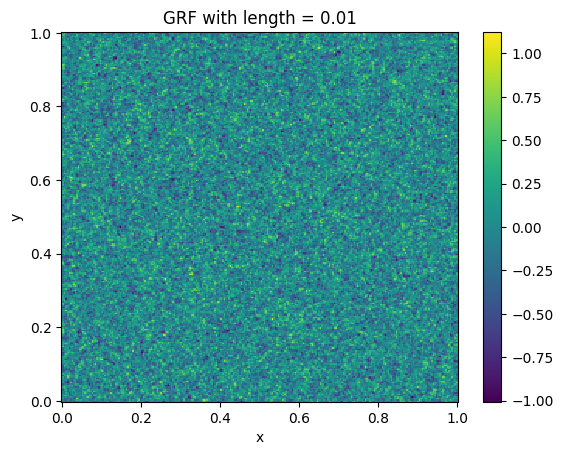

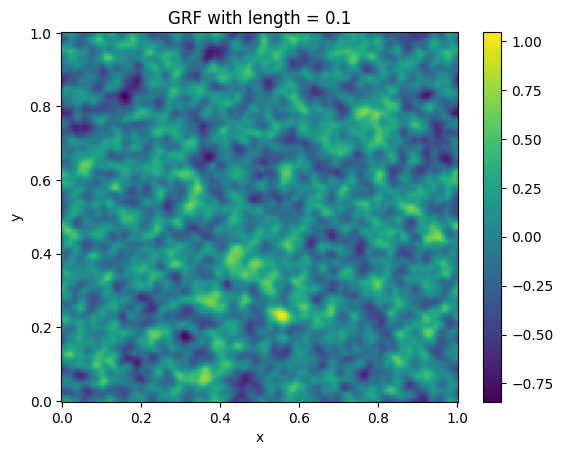

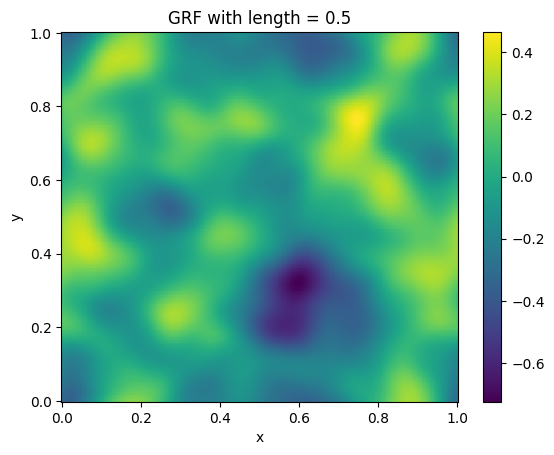

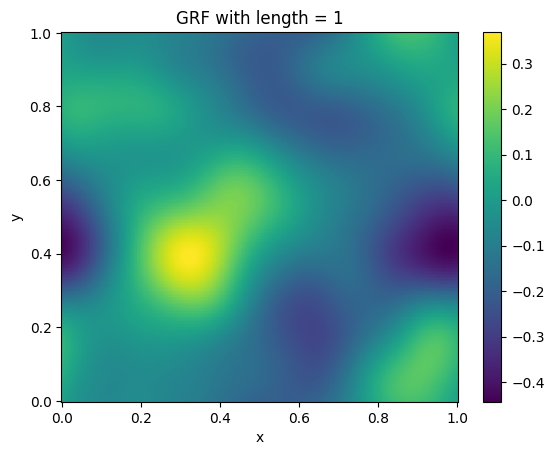

In [ ]:
# updated version of GRF2d with optional tau parameter
def GRF2d_exponential(Nx, Ny, alpha, length):
    # define wavenumber and coefficients
    kx = np.fft.fftfreq(Nx,1/Nx)  # wavenumbers
    ky = np.fft.rfftfreq(Ny,1/Ny) # wavenumbers
    Kx,Ky = np.meshgrid(kx,ky)    # k = (kx,ky) wavevector in 2d
    K = np.sqrt(Kx**2+Ky**2).T    # wavenumber magnitude |k|

    #
    assert tau > 0, 'tau must be positive'
    lmbda = np.exp(-(length*K)**alpha)  # decay parameters
    eta = (
        np.random.randn(*K.shape) + 1j*np.random.randn(*K.shape)
    ) # random coefficients

    # Fourier coefficients of u
    uhat = lmbda*eta

    # normalization (just to get output function in a more-or-less reasonable range)
    normalization = 8 * np.sqrt(np.sum(lmbda**2))

    # transform back via inverse FT
    u = np.fft.irfft2(uhat, norm='forward') / normalization

    return u

# generate a few 2d fields
N = 256 # number of grid points
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)
alpha = 1 # fixing alpha value
length_vals = [0.01,0.1,0.5,1]

for i in range(4):
    length = length_vals[i]
    u = GRF2d_exponential(N,N,alpha,length) # generate random field

    # plot
    plt.figure()
    plt.pcolor(X,Y,u)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GRF with length = {length}')
    plt.show()